# Classificação dos fungos Pós-processamento (Depois da manipulação das imagens)

In [1]:

import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import time


In [2]:
Dataset_path = "../defungi_dataset_processed"
Image_size = (64, 128)
HOG_orientation = 9
HOG_pixels_per_cell = (8, 8)
HoG_cells_per_block = (2, 2)


In [3]:
# extrair dados

data = []
labels = []

classes_names = [d for d in os.listdir(Dataset_path) if os.path.isdir(os.path.join(Dataset_path, d))]
label_mapping = {name: i for i, name in enumerate(classes_names)}

for nome_classe,label_id in label_mapping.items():
    class_path = os.path.join(Dataset_path, nome_classe)
    for nome_imagem in os.listdir(class_path):
        image_path = os.path.join(class_path,nome_imagem)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Erro ao carregar a imagem: {image_path}")
            continue

        resized_image = cv2.resize(image, Image_size)
        gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
        data.append(gray_image)
        labels.append(label_id)



In [4]:
# transformar as imagens em HOG features
hog_features = []
for image in data:
    features = hog(image, 
                   orientations=HOG_orientation, 
                   pixels_per_cell=HOG_pixels_per_cell, 
                   cells_per_block=HoG_cells_per_block, 
                   block_norm='L2-Hys', 
                   visualize=False)
    hog_features.append(features)


In [5]:
X = np.array(hog_features)
y = np.array(labels)

# Dividir o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

print(f"Total de imagens: {len(data)}")
print(f"Total de classes: {len(classes_names)}")
print(f"Total de imagens de treino: {len(X_train)}")
print(f"Total de imagens de teste: {len(X_test)}")


Total de imagens: 9114
Total de classes: 5
Total de imagens de treino: 7291
Total de imagens de teste: 1823


# SVM

In [6]:
model = SVC(kernel='linear', probability=True,C=1.0, random_state=42)
model.fit(X_train, y_train)
print("Modelo treinado com sucesso!")
y_pred = model.predict(X_test)


Modelo treinado com sucesso!


In [7]:
accuracy = accuracy_score(y_test, y_pred)
print("\n--- RESULTADOS DA AVALIAÇÃO ---")
print(f"Acurácia do modelo: {accuracy:.2%}")
print("\nRelatório de Classificação:")
    
# Inverte o mapa de rótulos para mostrar os nomes das classes no relatório
target_names = [name for name, i in sorted(label_mapping.items(), key=lambda item: item[1])]
print(classification_report(y_test, y_pred, target_names=target_names))


--- RESULTADOS DA AVALIAÇÃO ---
Acurácia do modelo: 46.35%

Relatório de Classificação:
              precision    recall  f1-score   support

         TSH       0.60      0.71      0.65       884
        BASH       0.33      0.25      0.28       486
         GMA       0.12      0.13      0.13       155
         SHC       0.32      0.29      0.31       157
         BBH       0.29      0.24      0.26       141

    accuracy                           0.46      1823
   macro avg       0.33      0.32      0.33      1823
weighted avg       0.44      0.46      0.45      1823



# Matriz de confusão

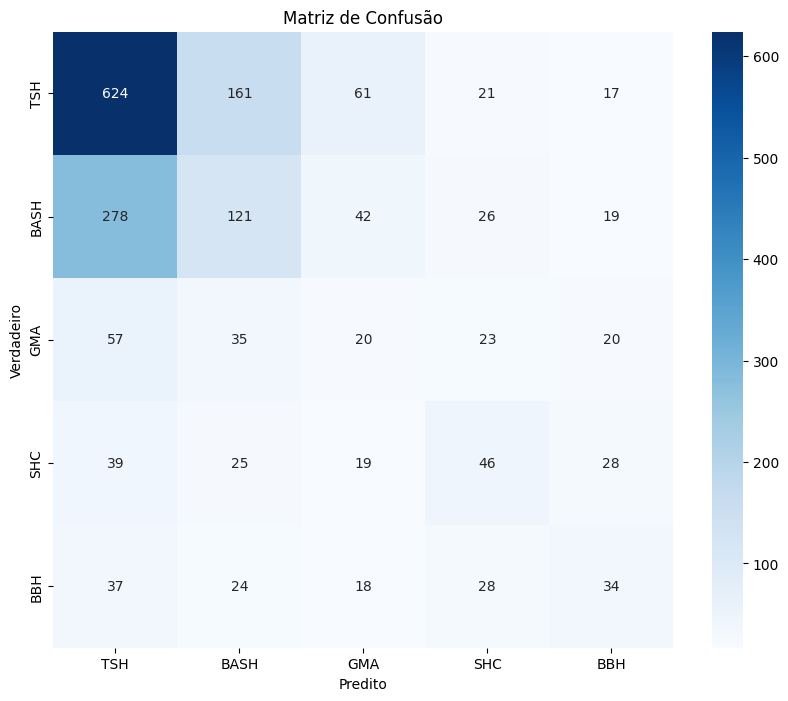

In [8]:
# matriz de confusão
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

# KNN

In [9]:
model_knn = KNeighborsClassifier()

# Busca por hiperparâmetros (número de vizinhos) usando GridSearchCV
param_grid = {'n_neighbors': [5]}  # Testando diferentes valores de k
grid_search = GridSearchCV(model_knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Obtendo o melhor modelo
model_knn = grid_search.best_estimator_
print(f"Modelo KNN treinado com sucesso! Melhor número de vizinhos: {grid_search.best_params_['n_neighbors']}")

# Avaliação com validação cruzada
cv_scores = cross_val_score(model_knn, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nAcurácia média na validação cruzada (5-fold): {np.mean(cv_scores):.2%} ± {np.std(cv_scores):.2%}")

# Previsões no conjunto de teste
y_knn_pred = model_knn.predict(X_test)

Modelo KNN treinado com sucesso! Melhor número de vizinhos: 5

Acurácia média na validação cruzada (5-fold): 44.93% ± 0.42%


In [10]:
accuracy = accuracy_score(y_test, y_knn_pred)
print("\n--- RESULTADOS DA AVALIAÇÃO ---")
print(f"Acurácia do modelo: {accuracy:.2%}")
print("\nRelatório de Classificação:")
    
# Inverte o mapa de rótulos para mostrar os nomes das classes no relatório
target_names = [name for name, i in sorted(label_mapping.items(), key=lambda item: item[1])]
print(classification_report(y_test, y_knn_pred, target_names=target_names))


--- RESULTADOS DA AVALIAÇÃO ---
Acurácia do modelo: 45.91%

Relatório de Classificação:
              precision    recall  f1-score   support

         TSH       0.66      0.75      0.70       884
        BASH       0.33      0.04      0.08       486
         GMA       0.15      0.16      0.15       155
         SHC       0.24      0.66      0.35       157
         BBH       0.18      0.18      0.18       141

    accuracy                           0.46      1823
   macro avg       0.31      0.36      0.29      1823
weighted avg       0.45      0.46      0.42      1823



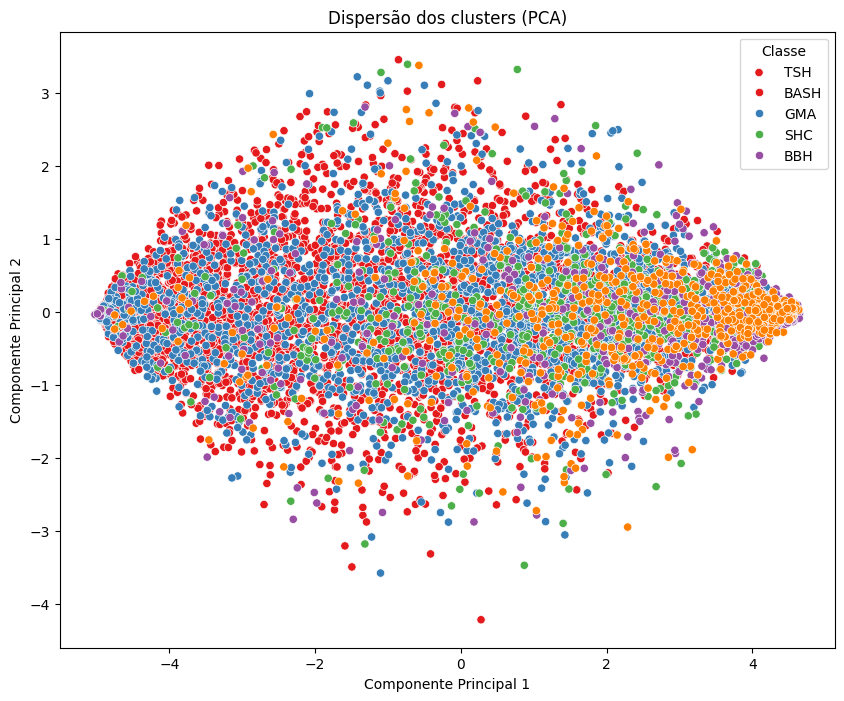

In [11]:
from sklearn.decomposition import PCA

# Visualização da dispersão dos clusters usando PCA para reduzir a dimensionalidade

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='Set1', legend='full')
plt.title('Dispersão dos clusters (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Classe', labels=target_names)
plt.show()

# CNN

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2025-07-24 17:20:42.368993: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753388442.379629  302878 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753388442.383087  302878 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753388442.391149  302878 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753388442.391157  302878 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753388442.391158  302878 computation_placer.cc:177] computation placer alr

In [13]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(512, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [14]:
# Configurar ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

In [15]:
# Carregar dados
train_generator = train_datagen.flow_from_directory(
    Dataset_path,
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    Dataset_path,
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)


Found 8206 images belonging to 5 classes.
Found 908 images belonging to 5 classes.


In [16]:
# Criar e treinar o modelo
input_shape = (128, 128, 1)
num_classes = len(train_generator.class_indices)
model = create_cnn_model(input_shape, num_classes)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.samples // 32,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

print("Modelo treinado com sucesso!")

/home/luiz/.pyenv/versions/temfungai310/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1753388444.065217  302878 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13362 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/50


/home/luiz/.pyenv/versions/temfungai310/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1753388446.943460  316949 service.cc:152] XLA service 0x7fc3d0018380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753388446.943473  316949 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2025-07-24 17:20:47.000541: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753388447.352818  316949 cuda_dnn.cc:529] Loaded cuDNN version 91002


  5/256 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.3235 - loss: 3.1612

I0000 00:00:1753388451.383743  316949 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4114 - loss: 2.2046

2025-07-24 17:21:06.874946: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_189_0', 44 bytes spill stores, 44 bytes spill loads

2025-07-24 17:21:07.178607: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_189', 484 bytes spill stores, 484 bytes spill loads



256/256 ━━━━━━━━━━━━━━━━━━━━ 24s 68ms/step - accuracy: 0.4117 - loss: 2.2009 - val_accuracy: 0.4844 - val_loss: 1.6048
Epoch 2/50
  1/256 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4375 - loss: 1.2941

/home/luiz/.pyenv/versions/temfungai310/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4375 - loss: 1.2941 - val_accuracy: 0.4833 - val_loss: 1.5732
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4824 - loss: 1.3096 - val_accuracy: 0.4833 - val_loss: 1.1698
Epoch 4/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5938 - loss: 0.9418 - val_accuracy: 0.4833 - val_loss: 1.1707
Epoch 5/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4967 - loss: 1.2403

256/256 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4967 - loss: 1.2403 - val_accuracy: 0.5145 - val_loss: 1.2012
Epoch 6/50
  1/256 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6562 - loss: 0.9846

256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6562 - loss: 0.9846 - val_accuracy: 0.5290 - val_loss: 1.1850
Epoch 7/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5096 - loss: 1.2188

256/256 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.5096 - loss: 1.2188 - val_accuracy: 0.5446 - val_loss: 1.2896
Epoch 8/50
  1/256 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5000 - loss: 1.3703

256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5000 - loss: 1.3703 - val_accuracy: 0.5458 - val_loss: 1.2891
Epoch 9/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.5049 - loss: 1.2324 - val_accuracy: 0.5402 - val_loss: 1.3224
Epoch 10/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4062 - loss: 1.3499 - val_accuracy: 0.5368 - val_loss: 1.3221
Epoch 11/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.5147 - loss: 1.2034 - val_accuracy: 0.4877 - val_loss: 1.5918
Epoch 12/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5000 - loss: 1.3058 - val_accuracy: 0.4844 - val_loss: 1.5757
Epoch 13/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.5161 - loss: 1.1937 - val_accuracy: 0.2913 - val_loss: 1.4330
Modelo treinado com sucesso!


In [17]:
# Avaliação no conjunto de teste
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    Dataset_path,
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test = test_generator.classes

Found 9114 images belonging to 5 classes.
282/285 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

2025-07-24 17:22:27.741522: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_174_0', 36 bytes spill stores, 36 bytes spill loads

2025-07-24 17:22:28.021260: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_181', 4 bytes spill stores, 4 bytes spill loads

2025-07-24 17:22:28.063293: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_174', 488 bytes spill stores, 488 bytes spill loads



285/285 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step


In [18]:
# Resultados
accuracy = accuracy_score(y_test, y_pred)
print("\n--- RESULTADOS DA AVALIAÇÃO ---")
print(f"Acurácia do modelo: {accuracy:.2%}")

# Relatório de classificação
target_names = list(train_generator.class_indices.keys())
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=target_names))



--- RESULTADOS DA AVALIAÇÃO ---
Acurácia do modelo: 48.32%

Relatório de Classificação:
              precision    recall  f1-score   support

        BASH       0.00      0.00      0.00      2334
         BBH       0.00      0.00      0.00       739
         GMA       0.00      0.00      0.00       819
         SHC       0.00      0.00      0.00       818
         TSH       0.48      1.00      0.65      4404

    accuracy                           0.48      9114
   macro avg       0.10      0.20      0.13      9114
weighted avg       0.23      0.48      0.32      9114



/home/luiz/.pyenv/versions/temfungai310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/luiz/.pyenv/versions/temfungai310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/luiz/.pyenv/versions/temfungai310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Classe prevista: TSH
Classe real: BASH
Resultado: ERROU


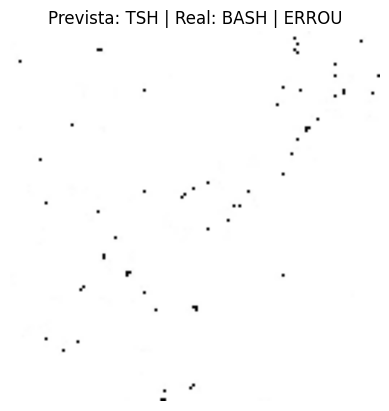

In [55]:
# Seleciona uma imagem do conjunto de teste do gerador (por exemplo, a primeira)
test_img_batch, test_label_batch = next(test_generator)
test_img = test_img_batch[0]
real_class = int(test_label_batch[0])

# Faz a predição
pred_prob = model.predict(np.expand_dims(test_img, axis=0))
pred_class = np.argmax(pred_prob, axis=1)[0]

# Verifica se acertou
acertou = pred_class == real_class
resultado = "ACERTOU" if acertou else "ERROU"

print(f"Classe prevista: {target_names[pred_class]}")
print(f"Classe real: {target_names[real_class]}")
print(f"Resultado: {resultado}")

plt.imshow(test_img.squeeze(), cmap='gray')
plt.title(f"Prevista: {target_names[pred_class]} | Real: {target_names[real_class]} | {resultado}")
plt.axis('off')
plt.show()

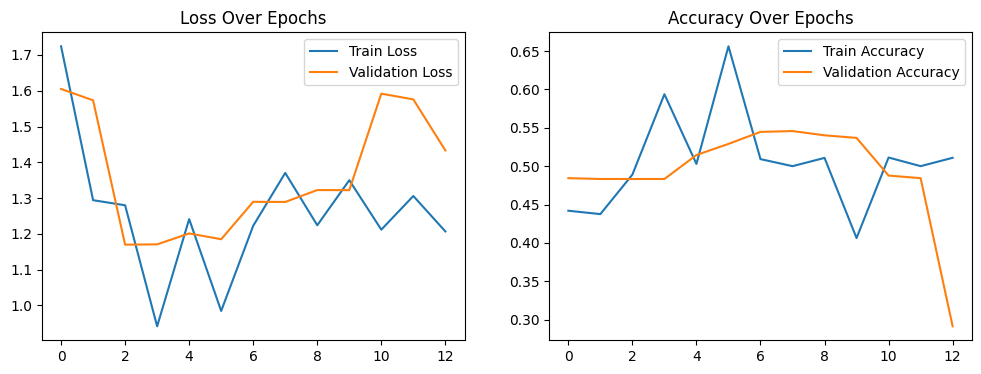

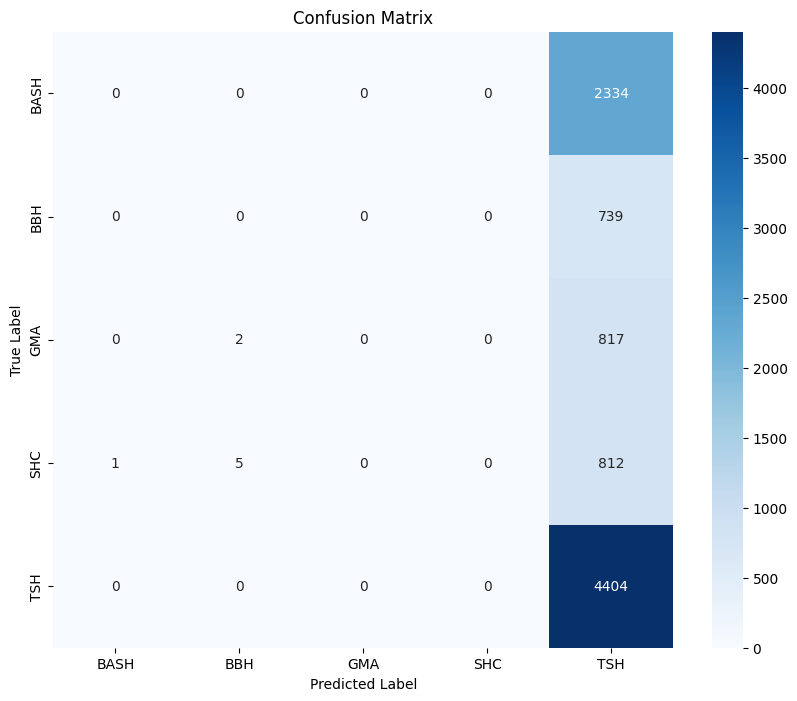

In [20]:
# Curvas de aprendizado
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

# Matriz de confusão com nomes corretos
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



Primeiras 10 imagens da pasta 'BBH':


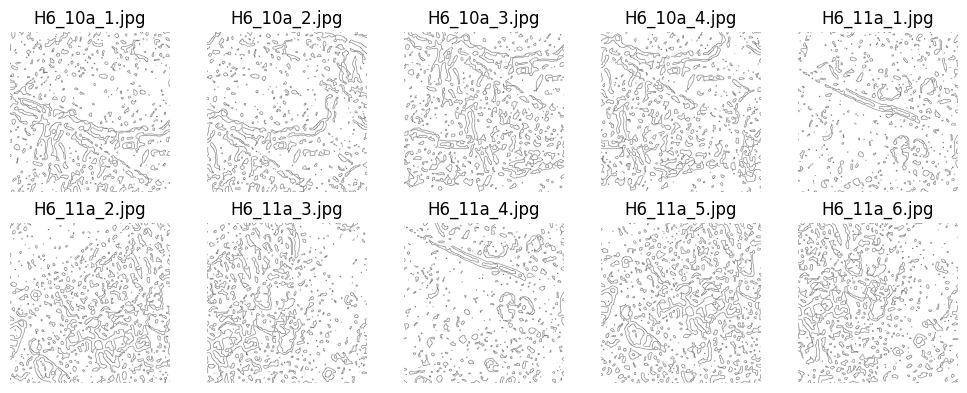


Primeiras 10 imagens da pasta 'BASH':


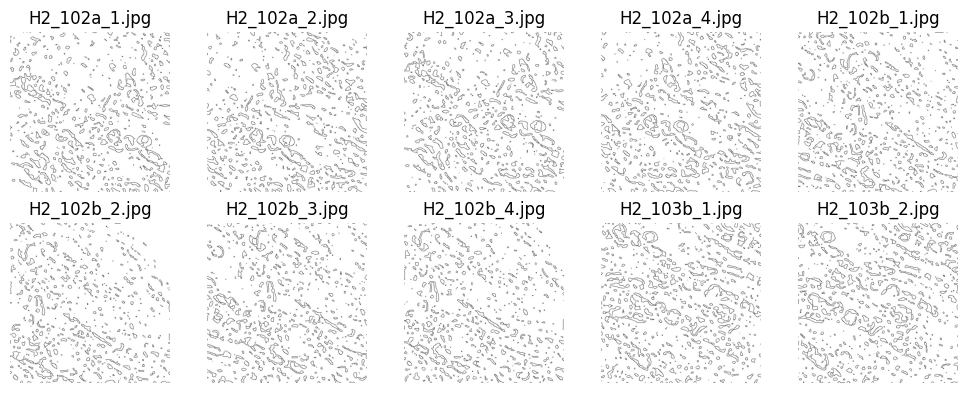

In [21]:
# Como ficaram as 10 primeiras e 10 últimas imagens de cada pasta
# Primeira pasta
first_class = classes_names[4]
first_class_path = os.path.join(Dataset_path, first_class)
first_class_images = os.listdir(first_class_path)[:10]
print(f"\nPrimeiras 10 imagens da pasta '{first_class}':")

# Carregar as imagens
images = []
for img_name in first_class_images:
    img_path = os.path.join(first_class_path, img_name)
    img = cv2.imread(img_path)
    if img is not None:
        images.append(img)

nrows, ncols = 2, 5  # 2 linhas, 5 colunas para 10 imagens
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(images):
        img_rgb = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)  # BGR → RGB para mostrar corretamente
        ax.imshow(img_rgb)
        ax.set_title(first_class_images[i])
    ax.axis("off")

plt.tight_layout()
plt.show()
#Segunda pasta
second_class = classes_names[1]
second_class_path = os.path.join(Dataset_path, second_class)
second_class_images = os.listdir(second_class_path)[:10]
print(f"\nPrimeiras 10 imagens da pasta '{second_class}':")

# Carregar as imagens
images = []
for img_name in second_class_images:
    img_path = os.path.join(second_class_path, img_name)
    img = cv2.imread(img_path)
    if img is not None:
        images.append(img)

nrows, ncols = 2, 5  # 2 linhas, 5 colunas para 10 imagens
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(images):
        img_rgb = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)
        ax.set_title(second_class_images[i])
    ax.axis("off")

plt.tight_layout()
plt.show()